# SETUP (restart after this)

In [1]:
# -*- coding: utf-8 -*-
# --- Setup: Google auth + Drive + NanoBanana Pro deps ---

import sys, os, subprocess, textwrap, importlib

from google.colab import auth, drive
auth.authenticate_user()
drive.mount('/content/drive')

!pip install fal-client requests
!pip -q install --upgrade pip
!pip install -U "google-genai>=1.40.0" pillow numpy opencv-python-headless matplotlib gspread google-auth google-auth-oauthlib google-api-python-client piexif tqdm

print("✅ Setup done for NanoBanana Pro.")


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 52.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-auth==2.43.0, but you have google-auth 2.41.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
gradio 5.49.1 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.
✅ Setup done for NanoBanana Pro.


In [4]:
import os, re, fnmatch, math, uuid, pytz, random, gc, tempfile, traceback
from datetime import datetime
import numpy as np
from PIL import Image, ImageOps, ImageEnhance, ImageChops, ImageFilter


# Select angles

In [136]:
fr_lft = True #@param {type:"boolean"}
fr_rght = True #@param {type:"boolean"}
fr_cl = True #@param {type:"boolean"}
bc_lft = True #@param {type:"boolean"}
bc_rght = True #@param {type:"boolean"}
lft = True #@param {type:"boolean"}
rght = True #@param {type:"boolean"}
bc_ = True #@param {type:"boolean"}
fr_ = True #@param {type:"boolean"}
fr_cl_btm = True #@param {type:"boolean"}
fr_cl_tp = True #@param {type:"boolean"}


names = ["fr_lft","fr_rght","fr_cl","bc_lft","bc_rght","lft","rght","bc_","fr_","fr_cl_btm","fr_cl_tp"]
ALLOWED_BASES = [n for n in names if locals()[n]]

# CONFIG

In [137]:
# --- Unified CONFIG ---
from google.colab import userdata
FAL_KEY = userdata.get('FAL_KEY')

# Selection mode: list only
RUN_MODE = "sku_list"     #@param ["sku_list"]

# For RUN_MODE == "sku_list"
SKU_CSV = "28726, 28813, 28787, 28788, 28792, 29125, 28624, 28623, 28165, 28166, 28167, 28168, 28169, 28170, 28159, 28160, 28161, 28675, 28282, 28261, 28892, 29007, 28269, 28898, 28232, 28914, 28915, 28891, 28200, 28828, 28926, 28929, 28851, 28845, 28844, 28839, 28924, 28925, 28736, 29017, 29250, 28894, 28873, 28874"  #@param {type:"string"}

# Paths
BASE_PHOTOS_ROOT  = "/content/drive/MyDrive/Dazzl/SikSilk/SKSLK_MODELS/"
GARMENTS_ROOT     = "/content/drive/MyDrive/Dazzl/SikSilk/AlexGens/SikSilk/"


# Filename/dir policy
VALID_EXTENSIONS  = (".png", ".jpg", ".jpeg", ".PNG", ".JPG", ".JPEG")
IGNORE_DIRS       = {"old", "__MACOSX", ".ds_store", "Ricardo", "toweling"}
SKIP_FILENAME_TOKENS_CSV   = "mask, generated, freelance, _sec, _backup"   # substrings to skip
SKIP_BASENAME_SUFFIXES_CSV = "_sec"                             # stem endings to skip
REQUIRE_CUT_IN_FILENAME    = False   #@param {type:"boolean"}
PREFER_AGNOSTIC_MASKS = True #@param {type:"boolean"}
secondary_garment = True #@param {type:"boolean"}
SECONDARY_GARMENT = secondary_garment

# Cropping / paste-back (square 1:1, generous garment margin)
CROP_PADDING      = 300        # px padding around garment when building crop
UPPER_PADDING     = 200        # extra padding above garment
HORIZ_PADDING     = 150        # horizontal padding
MASK_EXPAND_PX    = 80        # outward growth before feather
MASK_FEATHER_PX   = 30         # Gaussian sigma for feathering
CROP_MIN_MARGIN   = 20        # minimum margin even if mask touches edge

TARGET_ASPECT = (1, 1)         # enforce square crops for 1:1 generations

# NanoBanana Pro (Google GenAI)
NANOBANANA_MODEL_ID = "gemini-3-pro-image-preview"
GEN_ASPECT_RATIO    = "1:1"
GEN_IMAGE_SIZE      = "4K" #@param ["1K", "2K", "4K"]


TRYON_PROMPT = """You are an expert virtual try-on AI. You will be given a 'model image' and a 'garment image'. Your task is to create a new photorealistic image where the person from the 'model image' is wearing the clothing from the 'garment image'.

**Crucial Rules:**
1.  **Complete Garment Replacement:** You MUST completely REMOVE and REPLACE the clothing item worn by the person in the 'model image' with the new garment. No part of the original clothing (e.g., collars, sleeves, patterns) should be visible in the final image.
2.  **Preserve the Model:** The person's face, hair, body shape, and pose from the 'model image' MUST remain unchanged, pixel-for-pixel.
3.  **Preserve the Background:** The entire background from the 'model image' MUST be preserved perfectly, pixel-for-pixel.
4.  **Apply the Garment:** Realistically fit the new garment onto the person. It should adapt to their pose with natural folds, shadows, and lighting consistent with the original scene.
5.  **Output:** Return ONLY the final, edited image. Do not include any text."""

SECONDARY_TRYON_PROMPT = """You are an expert virtual try-on AI. You will be given a 'model image' and a 'garment image'. Your task is to create a new photorealistic image where the person from the 'model image' is wearing the clothing from the 'garment image' as a complementary garment to their main.

**Crucial Rules:**
1.  **Complete {sec_type} Garment Replacement:** You MUST completely REMOVE and REPLACE the {sec_type} clothing item worn by the person in the 'model image' with the new {sec_type} garment. No part of the original cloth (e.g., collars, sleeves, patterns) should be visible in the final image.
2.  **Preserve the Model:** The person's face, hair, body shape, and pose from the 'model image' MUST remain unchanged, pixel-for-pixel.
3.  **Preserve the Background:** The entire background from the 'model image' MUST be preserved perfectly, pixel-for-pixel.
4.  **Apply the {sec_type} Garment:** Realistically fit the new {sec_type} garment onto the person. Even if only a small part of it is in frame. It should adapt to their pose with natural folds, shadows, and lighting consistent with the original scene.
5.  **Output:** Return ONLY the final, edited image. Do not include any text."""

# SAM3 segmentation (fal.ai)
FAL_SAM_MODEL_ID = "fal-ai/sam-3/image"
MASK_MAX_SIZE     = 1024   # px max side sent for segmentation
MASK_PROMPT_TEMPLATE = "{category}"


# Sheet-related (Ops removed) kept only for Gen Log appends
SPREADSHEET_ID = "1Kbq9__sEUQiuDPuza5Xy_hRyIn8pUvmfFj6vhPBrp8Y"
GEN_LOG_SHEET  = "Gen Log"

# Misc
SHOW_VISUALS = True
TIMEZONE     = "Europe/Lisbon"
OPERATOR     = "Ivan"
OUTPUT_DIR   = "/content/drive/MyDrive/Dazzl/SikSilk/SS_OUTPUT_FOLDER/v1-3/" #@param {type:"string"}


# === Garment/type taxonomy (kept) ===
ALLOWED_GARMENT_TYPES = [
    "hoodie","jeans","joggers","shorts","sweater","swimwear",
    "t-shirt","shirts","track top","trousers","twinset","polo","vests","shirts"
]
TOP_GARMENTS    = ["t-shirt","shirt","sweater","hoodie","track top","vest"]
BOTTOM_GARMENTS = ["shorts","joggers","trousers","jeans", "pants", "swimwear"]
TWINSET_TYPES   = ["twinset"]

# === Details tokens ===
ALLOWED_DETAIL_TYPES = ["crest","logo","patch"]

# Angle sheet tokens (kept for compatibility, not used in v1.3)
ANGLE_NEEDS_REGENERATE_TOKEN = "Regenerate"
ENFORCE_BAN_SUBSTRINGS     = True
BANNED_SUBSTRINGS_CSV      = "wrong, pair, combo"
ENFORCE_REQUIRE_SUBSTRINGS = False
REQUIRED_SUBSTRINGS_CSV    = ""
REQUIRED_SUBSTRINGS_MODE   = "ANY"   # "ANY" | "ALL"

def normalize_sku_list(sku_csv: str) -> str:
    skus = []
    for raw in sku_csv.split(','):
        sku = raw.strip().upper()
        match = re.search(r'(\d+)', sku)
        if match:
            sku_number = match.group(1)
            skus.append(f"SS-{sku_number}")
    # Return as CSV string
    return ", ".join(skus)

SKU_CSV = normalize_sku_list(SKU_CSV)

print("✅ Config ready for NanoBanana Pro v1.3")


✅ Config ready for NanoBanana Pro v1.3


# UTILS

In [138]:
# --- Core utilities: normalization, angles, walking, masks (agnostic-first) ---

import os, re, fnmatch, math, uuid, pytz, random, gc, tempfile, traceback
from datetime import datetime
import numpy as np
from PIL import Image, ImageOps, ImageEnhance, ImageChops, ImageFilter



# Parsers
def _parse_csv_list(s):  return [x.strip().casefold() for x in (s or "").split(",") if x.strip()]
BANNED_SUBSTRINGS       = _parse_csv_list(BANNED_SUBSTRINGS_CSV)
REQUIRED_SUBSTRINGS     = _parse_csv_list(REQUIRED_SUBSTRINGS_CSV)
SKIP_FILENAME_TOKENS    = set(_parse_csv_list(SKIP_FILENAME_TOKENS_CSV))
SKIP_BASENAME_SUFFIXES  = tuple(_parse_csv_list(SKIP_BASENAME_SUFFIXES_CSV))

# Normalizers
def _norm_sku(s):
    if s is None: return ""
    s = str(s).replace("\u00A0"," ")
    s = " ".join(s.split())
    return s.casefold()

def _norm_angle(s):
    s = (s or "").strip().lower()
    return s.strip("_ ").replace("-", "_")

# Angle aliases
ANGLE_ALIASES = {
    "fr_cl":   ["fr", "fr_"],
    "fr":      ["fr_cl"],
    "bc_lft":  ["bc", "bc_"],
    "bc_rght": ["bc", "bc_"],
}


# --- Helpers to keep outputs strict, sources flexible ---
def expand_as_list(angles):
    exp = list(expand_allowed_angles(angles))
    exp = [_norm_angle(a) for a in exp]
    exp.sort(key=len, reverse=True)  # prefer 'fr_cl' over 'fr'
    return exp

def pick_target_angle(source_angle: str, allowed_outputs: set) -> str | None:
    s = _norm_angle(source_angle)
    for target in allowed_outputs:
        fam = {_norm_angle(x) for x in expand_allowed_angles([target])}
        if s in fam:
            return _norm_angle(target)
    return None


def expand_allowed_angles(angles):
    expanded = set()
    for a in (angles or []):
        a_norm = _norm_angle(a)
        expanded.add(a_norm)
        for alt in ANGLE_ALIASES.get(a_norm, []):
            expanded.add(_norm_angle(alt))
    return expanded

# Ignore set
IGNORE_DIRS = {d.lower() for d in IGNORE_DIRS}

# Walkers
def _is_sku_folder(path: str) -> bool:
    if os.path.basename(os.path.normpath(path)).lower() in IGNORE_DIRS:
        return False
    try:
        for f in os.listdir(path):
            if os.path.isfile(os.path.join(path, f)) and f.lower().endswith(tuple(e.lower() for e in VALID_EXTENSIONS)):
                return True
    except Exception:
        return False
    return False

def iter_sku_folders(root: str):
    for dirpath, dirnames, filenames in os.walk(root):
        dirnames[:] = [d for d in dirnames if d.lower() not in IGNORE_DIRS]
        if any(f.lower().endswith(tuple(e.lower() for e in VALID_EXTENSIONS)) for f in filenames):
            yield dirpath

def resolve_targets(idents_csv: str, garments_root: str):
    """
    Accepts:
      • Plain SKU names, relative paths (Category/Subcategory/SKU), or absolute dirs
      • Glob patterns (e.g., 'Hoodies/*' or 'SKSLK_12*')
      • Directories that are NOT SKU leaves → expand to all descendant SKU leaves
    """
    idents = [s.strip() for s in idents_csv.replace("\n", ",").split(",") if s.strip()]
    if not idents: return [], []

    all_sku_dirs = list(iter_sku_folders(garments_root))
    rel_map = {p: os.path.relpath(p, garments_root) for p in all_sku_dirs}
    base_map = {p: os.path.basename(p) for p in all_sku_dirs}

    seen, out, unmatched = set(), [], []
    def add_path(p):
        ap = os.path.abspath(p)
        if os.path.isdir(ap):
            if _is_sku_folder(ap):
                if ap not in seen:
                    seen.add(ap); out.append(ap)
            else:
                # Expand directory to all descendant SKU leaves
                for leaf in iter_sku_folders(ap):
                    a = os.path.abspath(leaf)
                    if a not in seen:
                        seen.add(a); out.append(a)

    for ident in idents:
        before = len(out)
        # Absolute directory or SKU path
        if os.path.isabs(ident) and os.path.isdir(ident):
            add_path(ident)

        # Relative under garments root (dir or SKU)
        rel_candidate = os.path.join(garments_root, ident)
        if os.path.exists(rel_candidate):
            add_path(rel_candidate)

        # Glob/pattern over known SKU leaves (by basename or relative path)
        for p in all_sku_dirs:
            if fnmatch.fnmatch(base_map[p], ident) or fnmatch.fnmatch(rel_map[p], ident):
                add_path(p)

        if len(out) == before:
            unmatched.append(ident)

    out.sort()
    return out, unmatched

# Base/mask location resolution
def resolve_base_mask_dir(sku_folder: str,
                          garments_root: str = GARMENTS_ROOT,
                          base_root: str = BASE_PHOTOS_ROOT):
    """
    Map .../GARMENTS_ROOT/Category/Subcategory/SKU → .../BASE_ROOT/Category/Subcategory
    With robust fallbacks.
    """
    abs_sku = os.path.abspath(sku_folder)
    abs_gar = os.path.abspath(garments_root)
    try:
        rel = os.path.relpath(abs_sku, abs_gar)
    except Exception:
        rel = None

    if rel and not rel.startswith(".."):
        rel_parent = os.path.dirname(rel)
        cand = os.path.join(base_root, rel_parent)
        if os.path.isdir(cand): return cand

    subcat = os.path.basename(os.path.dirname(abs_sku))
    cat    = os.path.basename(os.path.dirname(os.path.dirname(abs_sku)))
    cand2  = os.path.join(base_root, cat, subcat)
    if os.path.isdir(cand2): return cand2

    cand3  = os.path.join(base_root, subcat)
    if os.path.isdir(cand3): return cand3
    return None

def _valid_ext(fname): return fname.lower().endswith(tuple(e.lower() for e in VALID_EXTENSIONS))

def _file_prefix_or_none(filename: str):
    low = filename.lower()
    for base in ALLOWED_BASES:
        if low.startswith(base): return base
    return None

def _find_image_with_stem_and_suffix(directory, stem, suffix=""):
    if not directory or not os.path.isdir(directory):
        return None
    stem = stem.lower()
    for file in os.listdir(directory):
        fname, fext = os.path.splitext(file)
        if fext.lower() in (".png",".jpg",".jpeg") and fname.lower() == f"{stem}{suffix}":
            return os.path.join(directory, file)
    return None

# --- Existence check in Google Drive by Colab-style path ---
def drive_file_exists_any_ext_at_colab_path(target_colab_path: str,
                                            exts=(".png", ".jpg", ".jpeg", ".PNG", ".JPG", ".JPEG")) -> bool:
    """
    Given a Colab-style *file* path (incl. a filename with any extension),
    checks if a file with the SAME stem exists in the same folder with any of the allowed extensions.
    """
    try:
        parent_id, desired_name = _resolve_parent_id_and_filename_from_colab_path(target_colab_path)
        stem, _ = os.path.splitext(desired_name)
        files = _list_children(parent_id, q_extra="")  # list once; filter locally
        allowed = {e.lower() for e in exts}
        for f in files:
            fname = f.get("name", "")
            s, e = os.path.splitext(fname)
            if s == stem and e.lower() in allowed:
                return True
        return False
    except Exception as e:
        print(f"⚠️ Ext-agnostic existence check failed for {target_colab_path}: {e}")
        return False


# === NEW: mask finding with AGNOSTIC priority ===
def find_mask_path(base_subcat_dir: str, stem_no_cut: str):
    """
    Priority:
      1) {stem}_mask_agnostic.(png|jpg|jpeg)
      2) {stem}_mask.(png|jpg|jpeg)
    """
    if not base_subcat_dir or not os.path.isdir(base_subcat_dir):
        return None

    candidates = []
    if PREFER_AGNOSTIC_MASKS:
      for ext in (".png",".jpg",".jpeg",".PNG",".JPG",".JPEG"):
          candidates.append(os.path.join(base_subcat_dir, f"{stem_no_cut}_mask_agnostic{ext}"))
    for ext in (".png",".jpg",".jpeg",".PNG",".JPG",".JPEG"):
        candidates.append(os.path.join(base_subcat_dir, f"{stem_no_cut}_mask{ext}"))

    for p in candidates:
        if os.path.exists(p):
            return p
    return None


def find_secondary_garment_path(folder_path: str, main_filename: str):
    """
    Locate the secondary garment paired with a primary garment file.
    Example: main 'bc_lft_cut.png' -> looks for 'bc_lft_sec_cut.(png|jpg)'.
    Falls back to a non-cut variant when REQUIRE_CUT_IN_FILENAME is False.
    """
    stem, _ = os.path.splitext(main_filename)
    has_cut = stem.endswith("_cut")
    core = stem[:-4] if has_cut else stem

    candidates = [f"{core}_sec_cut"]
    if not REQUIRE_CUT_IN_FILENAME:
        candidates.append(f"{core}_sec")
    if not has_cut:
        candidates.append(f"{stem}_sec_cut")

    seen = set()
    for cand in candidates:
        if cand in seen:
            continue
        seen.add(cand)
        for ext in VALID_EXTENSIONS:
            path = os.path.join(folder_path, f"{cand}{ext}")
            if os.path.exists(path):
                return path
    return None

# ──────────────────────────────────────────
# --- Aspect-ratio bbox (replaces square bbox usage) ---


def find_aspect_bbox(
    mask: Image.Image,
    aspect: tuple[int,int] = (1,1),   # width:height, e.g. (1280,1600)
    padding: int = 40,
    upper_padding: int | None = None,
    horiz_padding: int = 0,
    min_margin: int | None = None,
    allow_padding: bool = True,
):
    """
    Return a rectangular bbox [x0, y0, x1, y1] that fully contains the mask + padding
    and matches the requested aspect ratio. When allow_padding is True the box may
    extend outside the image; callers should pad when cropping to preserve aspect.
    """
    if min_margin is None:
        try:
            min_margin = int(MASK_EXPAND_PX + 3 * MASK_FEATHER_PX + 5)
        except Exception:
            min_margin = 40

    m = np.array(mask.convert("L"))
    h, w = m.shape
    ys, xs = np.where(m > 128)
    if xs.size == 0:
        raise ValueError("Mask has no white pixels!")

    x_min, x_max = int(xs.min()), int(xs.max())
    y_min, y_max = int(ys.min()), int(ys.max())

    if upper_padding is None:
        upper_padding = padding

    # Initial padded bbox (can go outside image bounds; padding applied later)
    x0 = x_min - horiz_padding - min_margin
    x1 = x_max + horiz_padding + min_margin
    y0 = y_min - upper_padding - min_margin
    y1 = y_max + padding + min_margin

    bw, bh = (x1 - x0), (y1 - y0)
    aw, ah = aspect
    target_ar = float(aw) / float(max(1, ah))

    def expand_to_aspect(x0, y0, x1, y1):
        bw = x1 - x0; bh = y1 - y0
        cur_ar = bw / float(max(1, bh))
        if cur_ar < target_ar:
            need_w = int(np.ceil(target_ar * bh))
            grow = max(0, need_w - bw)
            x0 -= grow // 2
            x1 += grow - grow // 2
        elif cur_ar > target_ar:
            need_h = int(np.ceil(bw / target_ar))
            grow = max(0, need_h - bh)
            y0 -= grow // 2
            y1 += grow - grow // 2
        return x0, y0, x1, y1

    x0, y0, x1, y1 = expand_to_aspect(x0, y0, x1, y1)

    if not allow_padding:
        x0, y0 = max(0, int(x0)), max(0, int(y0))
        x1, y1 = min(w, int(x1)), min(h, int(y1))
    else:
        x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)

    return [x0, y0, x1, y1]


def crop_with_padding(img: Image.Image, bbox, fill):
    """Crop using bbox (which may extend outside the image) and pad missing areas with fill."""
    x0, y0, x1, y1 = map(int, bbox)
    w, h = img.size
    tgt_w, tgt_h = x1 - x0, y1 - y0
    out = Image.new(img.mode, (tgt_w, tgt_h), fill)

    src_box = (
        max(0, x0),
        max(0, y0),
        min(w, x1),
        min(h, y1),
    )
    dst_xy = (max(0, -x0), max(0, -y0))

    if src_box[2] > src_box[0] and src_box[3] > src_box[1]:
        region = img.crop(src_box)
        out.paste(region, dst_xy)
    return out

WHITE_RGB = (255,255,255)

def flatten_alpha_to_white(img: Image.Image) -> Image.Image:
    if img.mode in ("RGBA","LA") or ("transparency" in img.info):
        bg = Image.new("RGB", img.size, WHITE_RGB)
        bg.paste(img, mask=img.split()[-1])
        return bg
    return img.convert("RGB")

def _tight_bbox_nonwhite_or_opaque(img: Image.Image):
    if img.mode in ("RGBA","LA") or ("transparency" in img.info):
        arr = np.asarray(img.convert("RGBA"))
        alpha = arr[...,3]
        fg = alpha > 0
    else:
        arr = np.asarray(img.convert("RGB"))
        fg = ~((arr[...,0]==255)&(arr[...,1]==255)&(arr[...,2]==255))
    if not np.any(fg): return None
    ys, xs = np.where(fg)
    x0, x1 = int(xs.min()), int(xs.max())+1
    y0, y1 = int(ys.min()), int(ys.max())+1
    return (x0,y0,x1,y1)

def crop_garment_keep_aspect(img: Image.Image) -> Image.Image:
    bbox = _tight_bbox_nonwhite_or_opaque(img)
    base = flatten_alpha_to_white(img)
    if bbox is None: return base
    full_bbox = (0,0,base.width,base.height)
    if bbox == full_bbox: return base
    return base.crop(bbox)

def to_centered_square(gar: Image.Image, fill=WHITE_RGB) -> Image.Image:
    w,h = gar.size; side = max(w,h)
    sq = Image.new("RGB", (side, side), fill)
    ox, oy = (side-w)//2, (side-h)//2
    sq.paste(gar, (ox,oy)); return sq


In [139]:
# --- Visualisation helpers (restored) ---

import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps

def open_upright(path) -> Image.Image:
    # EXIF-aware loader (same as before)
    with Image.open(path) as im:
        return ImageOps.exif_transpose(im)

def show_gallery(img_list, titles=None, cols=3, w=4):
    """
    Display PIL images in a flexible grid (identical behaviour to your original).
    Only renders if SHOW_VISUALS is True.
    """
    if not globals().get("SHOW_VISUALS", False):
        return

    n = len(img_list)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols * w, rows * w))

    for i, img in enumerate(img_list):
        plt.subplot(rows, cols, i + 1)
        # Accept PIL, torch tensors or numpy arrays (4-D batch ⇒ pick first)
        if isinstance(img, np.ndarray) and img.ndim == 4:
            img = img[0]  # (B,H,W,C) → (H,W,C)
        # Torch tensors are printed via duck-typing check to avoid hard import
        if "Tensor" in str(type(img)):
            img = img.detach().cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        if titles and i < len(titles):
            plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [140]:
import numpy as np
import cv2
from PIL import Image

def paste_crop_back_debug(
    full_img: Image.Image,
    edited_crop: Image.Image,
    crop_box,               # (x0, y0, x1, y1) in full_img coords
    crop_mask,              # H×W uint8/bool, garment=white in crop coords
    solid_expand_px: int = 8,   # grow the 100% opaque region
    halo_px: int = 40,          # thickness of the soft halo OUTSIDE solid
    feather_px: int = 20,       # Gaussian sigma for halo
    *,
    bin_thresh: int = 127,
    edge_feather_px: int = 15,  # clamp width at crop borders
):
    x0, y0, x1, y1 = map(int, crop_box)
    tgt_w, tgt_h   = (x1 - x0), (y1 - y0)

    # --- resize edited crop ---
    edit_rs = edited_crop.resize((tgt_w, tgt_h), Image.Resampling.LANCZOS)

    # --- 1) binary silhouette mask in crop coords ---
    mask_np = crop_mask
    if isinstance(mask_np, Image.Image):
        mask_np = np.array(mask_np.convert("L"))
    if mask_np.ndim == 3:
        mask_np = mask_np[..., 0]

    mask_np = cv2.resize(mask_np, (tgt_w, tgt_h), interpolation=cv2.INTER_NEAREST)
    mask_bin = (mask_np > bin_thresh).astype(np.uint8)

    # --- 2) solid = expanded garment, outer = solid + halo -------------------
    def dilate(mask, r):
        if r <= 0:
            return mask.copy()
        ksize = max(1, r * 2 + 1)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
        return cv2.dilate(mask, kernel, iterations=1)

    solid = dilate(mask_bin, solid_expand_px)               # fully opaque region
    outer = dilate(solid, halo_px)                          # solid + halo shell

    # band where we want partial alpha
    band = outer.clip(0, 1).astype(np.float32) * 255.0

    # --- 3) blur the band to get a smooth halo --------------------------------
    if feather_px > 0:
        band = cv2.GaussianBlur(
            band, (0, 0),
            sigmaX=feather_px,
            sigmaY=feather_px,
        )

    # --- 4) clamp halo near crop borders (no recursion) -----------------------
    H, W = band.shape
    ef = max(1, int(edge_feather_px))
    ef = min(ef, H // 2, W // 2)

    leaks_top    = band[0, :].max() > 0
    leaks_bottom = band[-1, :].max() > 0
    leaks_left   = band[:, 0].max() > 0
    leaks_right  = band[:, -1].max() > 0

    if leaks_top and ef > 0:
        ramp = np.linspace(0.0, 1.0, ef, endpoint=True).reshape(-1, 1)
        band[:ef, :] *= ramp
    if leaks_bottom and ef > 0:
        ramp = np.linspace(1.0, 0.0, ef, endpoint=True).reshape(-1, 1)
        band[-ef:, :] *= ramp
    if leaks_left and ef > 0:
        ramp = np.linspace(0.0, 1.0, ef, endpoint=True).reshape(1, -1)
        band[:, :ef] *= ramp
    if leaks_right and ef > 0:
        ramp = np.linspace(1.0, 0.0, ef, endpoint=True).reshape(1, -1)
        band[:, -ef:] *= ramp

    # --- 5) final alpha: 255 inside solid, halo in the band only --------------
    alpha = band.copy()
    alpha[solid > 0] = 255.0
    alpha = np.clip(alpha, 0, 255).astype(np.uint8)

    # --- 6) composite back into full image ------------------------------------
    mask_img = Image.fromarray(alpha, mode="L")
    region   = full_img.crop((x0, y0, x1, y1))
    comp     = Image.composite(edit_rs, region, mask_img)
    out_img  = full_img.copy()
    out_img.paste(comp, (x0, y0))

    return out_img, alpha


In [141]:
# --- NanoBanana Pro try-on (Google Cloud GenAI) ---

import os
from google import genai
from google.genai import types
from PIL import Image

def _load_gemini_api_key():
    key = os.getenv("GEMINI_API_KEY") or os.getenv("GEMINI_APIKEY")
    try:
        from google.colab import userdata
        key = key or userdata.get("GEMINI_API_KEY")
    except Exception:
        pass
    if not key:
        raise ValueError("Set GEMINI_API_KEY in environment or Colab userdata.")
    return key

genai_client = genai.Client(api_key=_load_gemini_api_key())

def _extract_first_image(resp):
    import io
    parts = []
    if hasattr(resp, "parts"):
        parts.extend(resp.parts)
    for cand in getattr(resp, "candidates", []):
        parts.extend(getattr(getattr(cand, "content", None), "parts", []) or [])

    for part in parts:
        if isinstance(part, Image.Image):
            return part
        as_image = getattr(part, "as_image", None)
        if callable(as_image):
            img = as_image()
            if isinstance(img, Image.Image):
                return img
        inline = getattr(part, "inline_data", None)
        if inline and getattr(inline, "data", None):
            return Image.open(io.BytesIO(inline.data)).convert("RGB")
    raise ValueError("No image returned from NanoBanana Pro response.")


def run_nanobanana_tryon(model_image: Image.Image, garment_image: Image.Image,
                         *, aspect_ratio: str = GEN_ASPECT_RATIO,
                         image_size: str = GEN_IMAGE_SIZE,
                         prompt: str | None = None):
    prompt_text = prompt or TRYON_PROMPT
    resp = genai_client.models.generate_content(
        model=NANOBANANA_MODEL_ID,
        contents=[
            prompt_text,
            "Model image:",
            model_image.convert("RGB"),
            "Garment image:",
            garment_image.convert("RGB"),
        ],
        config=types.GenerateContentConfig(
            response_modalities=["IMAGE"],
            image_config=types.ImageConfig(
                aspect_ratio=aspect_ratio,
                image_size=image_size,
            ),
        ),
    )
    img = _extract_first_image(resp)
    return img.convert("RGB")

print("✅ NanoBanana Pro client ready.")


✅ NanoBanana Pro client ready.


In [142]:

# --- SAM3 segmentation via fal.ai for on-the-fly garment masks ---

import base64, io, json
import fal_client
import requests

MASK_CACHE = {}
TOP_GARMENTS_SET = {g.casefold() for g in TOP_GARMENTS}
BOTTOM_GARMENTS_SET = {g.casefold() for g in BOTTOM_GARMENTS}

def _classify_garment_category(category: str) -> str | None:
    cat_norm = re.sub(r"\s+", " ", str(category or "").strip()).casefold()
    if cat_norm in TOP_GARMENTS_SET:
        return "top"
    if cat_norm in BOTTOM_GARMENTS_SET:
        return "bottom"
    return None


def _garment_category_from_path(path: str) -> str:
    parts = os.path.normpath(path).split(os.sep)
    lowers = [p.casefold() for p in parts]
    cat = None
    if "siksilk" in lowers:
        last_idx = len(lowers) - 1 - lowers[::-1].index("siksilk")
        if last_idx + 1 < len(parts):
            cat = parts[last_idx + 1]
    if not cat:
        try:
            rel = os.path.relpath(path, GARMENTS_ROOT)
            if not rel.startswith(".."):  # path is under garments root
                rel_parts = rel.split(os.sep)
                if rel_parts:
                    cat = rel_parts[0]
        except Exception:
            pass
    if not cat:
        parent = os.path.basename(os.path.dirname(path))
        cat = parent or "garment"
    cat_clean = re.sub(r"[_]+", " ", str(cat)).strip()
    cat_clean = re.sub(r"\s+", " ", cat_clean)
    return cat_clean or "garment"

def _build_mask_prompt(category: str, variant: str | None = None) -> str:
    prompt = MASK_PROMPT_TEMPLATE.format(category=str(category).strip(), variant=(variant or "").strip())
    prompt = prompt.strip()
    return prompt or str(category).strip()

def _strip_json_block(text: str) -> str:
    if "```json" in text:
        return text.split("```json", 1)[1].split("```", 1)[0].strip()
    if "```" in text:
        return text.split("```", 1)[1].split("```", 1)[0].strip()
    return text.strip()

def _mask_data_to_canvas(data_url: str, target_size):
    w, h = target_size
    if data_url.startswith("http"):
        resp = requests.get(data_url)
        resp.raise_for_status()
        raw = resp.content
    else:
        encoded = data_url.split(",", 1)[1] if "," in data_url else data_url
        encoded = encoded.strip()
        if not encoded:
            raise ValueError("Mask data missing from SAM response.")
        pad_len = (-len(encoded)) % 4
        if pad_len:
            encoded = encoded + "=" * pad_len
        try:
            raw = base64.b64decode(encoded)
        except Exception as e:
            raise ValueError(f"Invalid mask image data: {e}")
    mask_img = Image.open(io.BytesIO(raw)).convert("L")
    if mask_img.size != (w, h):
        mask_img = mask_img.resize((w, h), Image.Resampling.NEAREST)
    return mask_img.point(lambda v: 255 if v > 128 else 0)

def _image_to_data_url(img: Image.Image) -> str:
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode()

def _extract_masks_from_result(result):
    masks = []
    for m in result.get("masks") or []:
        if isinstance(m, dict):
            data = m.get("file_data") or m.get("data")
            ct = m.get("content_type") or "image/png"
            if data:
                if not str(data).startswith("data:"):
                    data = f"data:{ct};base64,{data}"
                masks.append(data)
            elif m.get("url"):
                masks.append(m["url"])
        elif isinstance(m, str):
            masks.append(m)
    img = result.get("image")
    if img:
        if isinstance(img, dict):
            data = img.get("file_data") or img.get("data")
            ct = img.get("content_type") or "image/png"
            if data:
                if not str(data).startswith("data:"):
                    data = f"data:{ct};base64,{data}"
                masks.append(data)
            elif img.get("url"):
                masks.append(img["url"])
        elif isinstance(img, str):
            masks.append(img)
    return masks

def _fetch_sam_masks(image_data_url: str, category: str):
    logs = []
    def _on_queue(update):
        if isinstance(update, fal_client.InProgress):
            for log in update.logs:
                msg = log.get("message")
                if msg:
                    logs.append(msg)
                    print(msg)
    result = fal_client.subscribe(
        FAL_SAM_MODEL_ID,
        arguments={
            "image_url": image_data_url,
            "text_prompt": category,
            "apply_mask": False,
            "return_multiple_masks": False,
            "max_masks": 1,
            "output_format": "png",
            "sync_mode": True,
        },
        with_logs=True,
        on_queue_update=_on_queue,
    )
    return _extract_masks_from_result(result)

def generate_mask_with_gemini(base_img_path: str, garment_folder: str, *, mask_variant: str | None = None):
    cache_key = (base_img_path, garment_folder, mask_variant or "primary")
    if cache_key in MASK_CACHE:
        return MASK_CACHE[cache_key]
    if not FAL_KEY:
        raise ValueError("Set FAL_KEY variable for fal.ai SAM3 segmentation.")
    category = _garment_category_from_path(garment_folder)
    main_class = _classify_garment_category(category)
    prompt_category = category
    if mask_variant:
        prompt_category = f"{category} ({mask_variant})"
        if "sec" in str(mask_variant).lower() and main_class:
            if main_class == "top":
                prompt_category = "bottom garment"
            elif main_class == "bottom":
                prompt_category = "top cloth"
    base_img = Image.open(base_img_path).convert("RGB")
    orig_w, orig_h = base_img.size
    inf_img = base_img
    scale = 1.0
    max_side = max(orig_w, orig_h)
    if max_side > MASK_MAX_SIZE:
        scale = MASK_MAX_SIZE / float(max_side)
        inf_img = base_img.resize((max(1, int(orig_w * scale)), max(1, int(orig_h * scale))), Image.Resampling.LANCZOS)

    print(f"Segmentation started for {os.path.basename(base_img_path)} [{prompt_category}] via fal.ai SAM3")
    prompt = _build_mask_prompt(prompt_category, mask_variant)
    masks = _fetch_sam_masks(_image_to_data_url(inf_img), prompt)
    if not masks:
        raise ValueError("SAM3 did not return any masks.")

    mask_canvas = None
    errors = []
    for m in masks:
        if not isinstance(m, str):
            continue
        try:
            mask_canvas = _mask_data_to_canvas(m, inf_img.size)
            break
        except Exception as e:
            errors.append(str(e))
            continue

    if mask_canvas is None:
        raise ValueError(f"SAM3 returned masks but none were usable: {errors}")

    if scale != 1.0:
        mask_canvas = mask_canvas.resize((orig_w, orig_h), Image.Resampling.NEAREST)
    result = (mask_canvas, f"sam3:{prompt_category}")
    MASK_CACHE[cache_key] = result
    return result

print("✅ SAM3 mask generation ready (fal.ai)")


✅ SAM3 mask generation ready (fal.ai)


In [143]:
# Colab cell — output routing + metadata helpers
import os, json
from PIL import PngImagePlugin

def ensure_dir(p):
    os.makedirs(p, exist_ok=True); return p

ensure_dir(OUTPUT_DIR)

def build_output_filename(sku_name: str, angle_code: str, ext=".png", suffix="") -> str:
    # Examples: SS-12345-fr_rght or SS-12345-bc_lft
    angle_clean = _norm_angle(angle_code)
    suffix = suffix or ""
    return f"{sku_name}-{angle_clean}{suffix}{ext}"


import json, piexif
from PIL import Image

def save_png_with_metadata(img, out_path, details_payload=None, quality=95):
    if details_payload:
        # Encode JSON as UTF-8 with an ASCII prefix per EXIF spec for UserComment
        payload = json.dumps(details_payload, ensure_ascii=False).encode("utf-8")
        user_comment = b"ASCII\x00\x00\x00" + payload  # indicates undefined/UTF-8
        exif_dict = {"0th": {}, "Exif": {piexif.ExifIFD.UserComment: user_comment}, "1st": {}, "GPS": {}, "Interop": {}}
        exif_bytes = piexif.dump(exif_dict)
        img.save(out_path, format="PNG", exif=exif_bytes)
    else:
        img.save(out_path, format="PNG")

import json, piexif
from PIL import Image, ImageOps


In [144]:
# --- Google APIs: gspread + Drive upload (Operations sync removed) ---

import google.auth
SCOPES = ["https://www.googleapis.com/auth/drive", "https://www.googleapis.com/auth/spreadsheets"]
creds, _ = google.auth.default(scopes=SCOPES)

import gspread
gs = gspread.authorize(creds)

from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
drive_svc = build("drive", "v3", credentials=creds)

FOLDER_MIME   = "application/vnd.google-apps.folder"
SHORTCUT_MIME = "application/vnd.google-apps.shortcut"
PATH_PREFIX   = "/content/drive/MyDrive/"

def _escape_name(name: str) -> str: return name.replace("'", r"'")

def _maybe_follow_shortcut(file_obj):
    if file_obj.get("mimeType") == SHORTCUT_MIME:
        sd = file_obj.get("shortcutDetails", {}) or {}
        return sd.get("targetId"), sd.get("targetMimeType")
    return file_obj.get("id"), file_obj.get("mimeType")

def _list_children(parent_id: str, q_extra: str, page_size: int = 1000):
    q = f"'{parent_id}' in parents and trashed = false"
    if q_extra: q += f" and ({q_extra})"
    resp = drive_svc.files().list(
        q=q, spaces="drive", pageSize=page_size,
        fields="files(id,name,mimeType,shortcutDetails)",
        includeItemsFromAllDrives=True, supportsAllDrives=True,
    ).execute()
    return resp.get("files", [])

def _find_folder_id(parent_id: str, name: str):
    files = _list_children(
        parent_id,
        q_extra=(
            f"name = '{_escape_name(name)}' and "
            f"(mimeType = '{FOLDER_MIME}' or mimeType = '{SHORTCUT_MIME}')"
        ),
    )

    # Direct folder match
    for f in files:
        if f["mimeType"] == FOLDER_MIME:
            return f["id"]

    # Shortcut to folder
    for f in files:
        if f["mimeType"] == SHORTCUT_MIME:
            tid, tmime = _maybe_follow_shortcut(f)
            if tmime == FOLDER_MIME:
                return tid

    # Fallback: match by case-insensitive name
    files = _list_children(
        parent_id,
        q_extra=(
            f"(mimeType = '{FOLDER_MIME}' or mimeType = '{SHORTCUT_MIME}')"
        ),
    )
    needle = name.strip().casefold()

    for f in files:
        if f.get("name", "").strip().casefold() == needle:
            tid, tmime = _maybe_follow_shortcut(f)
            if tmime == FOLDER_MIME:
                return tid

    return None


def _resolve_parent_id_and_filename_from_colab_path(colab_path: str):
    if not colab_path.startswith(PATH_PREFIX):
        raise ValueError(
            f"This helper supports only '{PATH_PREFIX}...'. Got: {colab_path}"
        )

    parts = colab_path[len(PATH_PREFIX):].strip("/").split("/")
    if not parts:
        raise ValueError("Path must include a file name.")

    parent_id = "root"

    for part in parts[:-1]:
        next_id = _find_folder_id(parent_id, part)
        if not next_id:
            raise FileNotFoundError(f"Folder not found in path: '{part}'")
        parent_id = next_id

    desired_name = parts[-1]
    return parent_id, desired_name


def upload_to_drive_folder(
    local_path: str,
    parent_folder_id: str,
    desired_name: str | None = None
):
    media = MediaFileUpload(local_path, resumable=True)
    body = {
        "name": desired_name or os.path.basename(local_path),
        "parents": [parent_folder_id],
    }

    file = (
        drive_svc.files()
        .create(
            body=body,
            media_body=media,
            fields="id, webViewLink, name, parents",
            supportsAllDrives=True,
        )
        .execute()
    )

    drive_svc.permissions().create(
        fileId=file["id"],
        body={"type": "anyone", "role": "reader"},
        fields="id",
        supportsAllDrives=True,
    ).execute()

    return file


def upload_file_and_append_to_sheet(
    local_path: str,
    target_colab_path: str,
    sku_name: str,
    angle: str,
    spreadsheet_id: str | None,
    worksheet_name: str | None,
):
    parent_id, desired_name = _resolve_parent_id_and_filename_from_colab_path(
        target_colab_path
    )

    uploaded = upload_to_drive_folder(local_path, parent_id, desired_name)
    file_id = uploaded["id"]

    file_url = (
        uploaded.get("webViewLink")
        or f"https://drive.google.com/file/d/{file_id}/view?usp=sharing"
    )
    folder_url = f"https://drive.google.com/drive/folders/{parent_id}"

    if spreadsheet_id and worksheet_name:
        ts = datetime.now(pytz.timezone(TIMEZONE)).strftime("%m-%d %H:%M:%S")
        uid = str(uuid.uuid4())

        sh = gs.open_by_key(spreadsheet_id)
        ws = sh.worksheet(worksheet_name)

        sku_cell = f'=HYPERLINK("{folder_url}"; "{sku_name}")'

        ws.append_row(
            [
                sku_cell,
                angle,
                ts,
                file_url,
                uid,
                "Girls need to check",
                OPERATOR,
            ],
            value_input_option="USER_ENTERED",
        )

    return {"file_url": file_url}


# BATCH HELPERS

In [145]:
# --- Batch processor  ---


def process_one_garment_folder(folder_path: str, allowed_angles=None):
    allowed_outputs_set = {_norm_angle(a) for a in (allowed_angles or [])}
    allowed_outputs = sorted(allowed_outputs_set)
    allowed_sources = expand_as_list(allowed_angles) if allowed_angles else None

    main_category = _garment_category_from_path(folder_path)
    main_class = _classify_garment_category(main_category)
    secondary_type = "bottom" if main_class == "top" else ("top" if main_class == "bottom" else "secondary")

    base_subcat_dir = resolve_base_mask_dir(folder_path)
    if not base_subcat_dir:
        print(f"⚠️ Cannot resolve base/mask dir for SKU: {folder_path}")
    files_sorted = sorted(os.listdir(folder_path))

    def source_priority(target_angle: str, filename: str) -> int:
        stem = os.path.splitext(filename.lower())[0]
        if target_angle == "fr_cl":
            if stem.startswith("fr_cl"):
                return 0
            if stem.startswith("fr_") and not (stem.startswith("fr_rght") or stem.startswith("fr_lft")):
                return 1
            if stem.startswith("fr_rght") or stem.startswith("fr_lft"):
                return 2
        if stem.startswith(target_angle):
            return 0
        return 3

    best_for_target = {}

    for file in files_sorted:
        low = file.lower()

        if allowed_sources and not any(low.startswith(src) for src in allowed_sources):
            continue
        if SKIP_FILENAME_TOKENS and any(tok in low for tok in SKIP_FILENAME_TOKENS):
            continue
        if REQUIRE_CUT_IN_FILENAME and ("cut" not in low):
            continue
        if not _valid_ext(file):
            continue

        matching_sources = [src for src in (allowed_sources or []) if low.startswith(src)] if allowed_sources else [_norm_angle(os.path.splitext(file)[0])]
        if allowed_sources and not matching_sources:
            continue

        target_candidates = set()
        for src in matching_sources:
            norm_src = _norm_angle(src)
            for target in (allowed_outputs or [norm_src]):
                fam = {_norm_angle(x) for x in expand_allowed_angles([target])}
                fam.add(_norm_angle(target))
                if norm_src in fam:
                    target_candidates.add(_norm_angle(target))

        if allowed_outputs and not target_candidates:
            continue

        for target_angle in sorted(target_candidates):
            base_img_path = _find_image_with_stem_and_suffix(base_subcat_dir, target_angle)
            if not base_img_path:
                print(f"⚠️ Missing BASE for target '{target_angle}' → skipping that target for {file}")
                continue

            mask_path = find_mask_path(base_subcat_dir, target_angle)
            if not mask_path:
                print(f"ℹ️ No local mask for target '{target_angle}', will request Gemini segmentation.")

            priority = source_priority(target_angle, low)
            current = best_for_target.get(target_angle)
            if current and priority >= current["priority"]:
                continue

            best_for_target[target_angle] = {
                "priority": priority,
                "file": file,
                "base_img_path": base_img_path,
                "mask_path": mask_path,
            }


    worklist = [
        (data["file"], target_angle, data["base_img_path"], data["mask_path"])
        for target_angle, data in best_for_target.items()
    ]
    worklist.sort(key=lambda x: x[1])

    sku_name = os.path.basename(folder_path)
    if allowed_sources:
        print(f"▶️  {sku_name}: {len(worklist)} image(s) to generate (outputs={sorted(list(allowed_outputs_set))}, sources={sorted(list(set(allowed_sources)))})")
    else:
        print(f"▶️  {sku_name}: {len(worklist)} image(s) to generate")

    if not worklist:
        return

    for idx, (file, target_angle, base_img_path, mask_path) in enumerate(worklist, start=1):
        print(f"   {idx:>3}/{len(worklist):<3}  {file}  | USING STRICT base/mask='{target_angle}'")
        garment_path = os.path.join(folder_path, file)

        sku_name = os.path.basename(folder_path)
        angle_code = _norm_angle(target_angle)
        main_suffix = "_onlymain" if SECONDARY_GARMENT else ""
        main_out_name = build_output_filename(sku_name, angle_code, ext=".png", suffix=main_suffix)
        final_out_name = build_output_filename(sku_name, angle_code, ext=".png", suffix="_both") if SECONDARY_GARMENT else None
        skip_name = final_out_name or main_out_name
        dest_check = os.path.join(OUTPUT_DIR, skip_name)

        if drive_file_exists_any_ext_at_colab_path(dest_check):
            stage_label = "secondary" if final_out_name else "main"
            print(f"      ⏭️  Skip: {skip_name} already exists in {OUTPUT_DIR} ({stage_label} target)")
            continue

        try:
            garment_img = flatten_alpha_to_white(open_upright(garment_path))
            base_full   = Image.open(base_img_path).convert("RGB")
            mask_label  = None
            mask_dir    = base_subcat_dir

            try:
                mask_full, mask_label = generate_mask_with_gemini(base_img_path, folder_path)
            except Exception as mask_err:
                if mask_path:
                    print(f"      ⚠️ Gemini mask failed for '{target_angle}', using disk mask instead: {mask_err}")
                    mask_full = Image.open(mask_path).convert("L")
                    mask_label = os.path.basename(mask_path)
                    mask_dir = os.path.dirname(mask_path)
                else:
                    print(f"      ❌ Gemini mask failed and no local mask for '{target_angle}': {mask_err}")
                    continue

            def perform_tryon_stage(stage_base_full, stage_mask_img, stage_garment_img, suffix, stage_label, mask_label, prompt_text=None):
                show_gallery(
                    [stage_garment_img, stage_base_full, stage_mask_img.convert("RGB")],
                    [f"Source garment (white BG) [{stage_label}]", f"Base photo [{angle_code}] [{stage_label}]", f"Mask [{mask_label}]"]
                )

                bbox = find_aspect_bbox(
                    stage_mask_img,
                    aspect=TARGET_ASPECT,
                    padding=CROP_PADDING,
                    upper_padding=UPPER_PADDING,
                    horiz_padding=HORIZ_PADDING,
                    min_margin=CROP_MIN_MARGIN,
                    allow_padding=True,
                )
                base_crop = crop_with_padding(stage_base_full, bbox, fill=WHITE_RGB)
                mask_crop = crop_with_padding(stage_mask_img.convert("L"), bbox, fill=0)
                show_gallery([base_crop, mask_crop.convert("RGB"), stage_garment_img], [f"Cropped base (1:1) [{stage_label}]", "Cropped mask", "Garment (white BG)"])

                print("🍌 started...")
                tryon_gen = run_nanobanana_tryon(
                    model_image=base_crop,
                    garment_image=stage_garment_img,
                    aspect_ratio=GEN_ASPECT_RATIO,
                    image_size=GEN_IMAGE_SIZE,
                    prompt=prompt_text or TRYON_PROMPT,
                )

                if tryon_gen.size != base_crop.size:
                    if tryon_gen.width != tryon_gen.height:
                        print(f"      ⚠️ Generator returned non-square image {tryon_gen.size}; resizing to {base_crop.size}.")
                    tryon_sq = tryon_gen.resize(base_crop.size, Image.Resampling.LANCZOS)
                else:
                    tryon_sq = tryon_gen

                final_img_local, alpha_dbg = paste_crop_back_debug(
                    full_img   = stage_base_full.copy(),
                    edited_crop= tryon_sq,
                    crop_box   = bbox,
                    crop_mask  = np.array(mask_crop),
                    solid_expand_px = max(5, MASK_EXPAND_PX // 4),
                    halo_px         = MASK_EXPAND_PX,
                    feather_px      = MASK_FEATHER_PX,
                    edge_feather_px = 15,   # tweak to taste
                )


                show_gallery(
                    [tryon_sq, alpha_dbg, final_img_local],
                    ["Try-on crop", "Alpha (debug)", "Final paste-back"],
                )

                out_name_local = build_output_filename(sku_name, angle_code, ext=".png", suffix=suffix)
                tmp_path_local = os.path.join("/tmp", out_name_local)

                save_png_with_metadata(final_img_local, tmp_path_local, details_payload=None)
                target_path_for_drive = os.path.join(OUTPUT_DIR, out_name_local)

                info = upload_file_and_append_to_sheet(
                    local_path       = tmp_path_local,
                    target_colab_path= target_path_for_drive,
                    sku_name         = sku_name,
                    angle            = angle_code,
                    spreadsheet_id   = SPREADSHEET_ID,
                    worksheet_name   = GEN_LOG_SHEET,
                )
                print(f"      ✅ Uploaded [{stage_label}] → {info['file_url']}")
                return final_img_local

            main_result = perform_tryon_stage(
                stage_base_full=base_full,
                stage_mask_img=mask_full,
                stage_garment_img=garment_img,
                suffix=main_suffix,
                prompt_text=TRYON_PROMPT,
                stage_label="main",
                mask_label=mask_label or "gemini-mask",
            )

            if SECONDARY_GARMENT:
                sec_mask_path = find_mask_path(mask_dir, f"{target_angle}_sec")

                sec_garment_path = find_secondary_garment_path(folder_path, file)
                if not sec_garment_path:
                    print(f"      ⚠️ Secondary garment missing for '{target_angle}' → kept main-only output.")
                    continue

                sec_mask_full = None
                sec_mask_label = None
                try:
                    sec_mask_full, sec_mask_label = generate_mask_with_gemini(
                        base_img_path,
                        folder_path,
                        mask_variant=f"{target_angle}_sec",
                    )
                except Exception as sec_mask_err:
                    if sec_mask_path:
                        print(f"      ⚠️ Secondary SAM3 mask failed for '{target_angle}', using disk mask instead: {sec_mask_err}")
                        sec_mask_full = Image.open(sec_mask_path).convert("L")
                        sec_mask_label = os.path.basename(sec_mask_path)
                    else:
                        print(f"      ❌ Secondary SAM3 mask failed and no local mask for '{target_angle}': {sec_mask_err}")
                        continue

                if sec_mask_full is None:
                    if sec_mask_path:
                        sec_mask_full = Image.open(sec_mask_path).convert("L")
                        sec_mask_label = os.path.basename(sec_mask_path)
                    else:
                        print(f"      ⚠️ Secondary mask missing for '{target_angle}' → kept main-only output.")
                        continue

                sec_garment_img = flatten_alpha_to_white(open_upright(sec_garment_path))

                perform_tryon_stage(
                    stage_base_full=main_result,
                    prompt_text=SECONDARY_TRYON_PROMPT.format(sec_type=secondary_type),
                    stage_mask_img=sec_mask_full,
                    stage_garment_img=sec_garment_img,
                    suffix="_both",
                    stage_label="secondary",
                    mask_label=sec_mask_label or (os.path.basename(sec_mask_path) if sec_mask_path else "gemini-mask"),
                )

        except Exception as e:
            print(f"      ❌ Error: {e}")


In [146]:
# --- Sheet-driven angle selection + runners ---

def build_sku_folder_index(garments_root: str):
    return { _norm_sku(os.path.basename(p)) : p for p in iter_sku_folders(garments_root) }

def run_list():
    targets, unmatched = resolve_targets(SKU_CSV, GARMENTS_ROOT)
    if not targets:
        print("⚠️ No matching SKU folders found.")
        if unmatched: print("Unmatched:", ", ".join(unmatched))
        return
    print(f"➡️  Will process {len(targets)} SKU(s).")
    for i, p in enumerate(targets, start=1):
        name = os.path.basename(p)
        print(f"\nSKU {i}/{len(targets)} ▶️  {name}")
        try:
            process_one_garment_folder(p, allowed_angles=ALLOWED_BASES)
            print(f"✅ Finished: {name}")
        except Exception as e:
            print(f"❌ Error in {name}: {e}")
    if unmatched:
        print("\nℹ️  Unmatched identifiers:")
        for u in unmatched: print("   -", u)
    print("\n🏁 List run complete.")


# DISPATCH

➡️  Will process 44 SKU(s).

SKU 1/44 ▶️  SS-28623


⚠️ Missing BASE for target 'bc_lft' → skipping that target for bc.JPG
⚠️ Missing BASE for target 'bc_rght' → skipping that target for bc.JPG
⚠️ Missing BASE for target 'bc_lft' → skipping that target for bc_cut.png
⚠️ Missing BASE for target 'bc_rght' → skipping that target for bc_cut.png
▶️  SS-28623: 5 image(s) to generate (outputs=['bc', 'bc_lft', 'bc_rght', 'fr', 'fr_cl', 'fr_cl_btm', 'fr_cl_tp', 'fr_lft', 'fr_rght', 'lft', 'rght'], sources=['bc', 'bc_lft', 'bc_rght', 'fr', 'fr_cl', 'fr_cl_btm', 'fr_cl_tp', 'fr_lft', 'fr_rght', 'lft', 'rght'])
     1/5    bc.JPG  | USING STRICT base/mask='bc'
Segmentation started for bc.png [Hoodies] via fal.ai SAM3


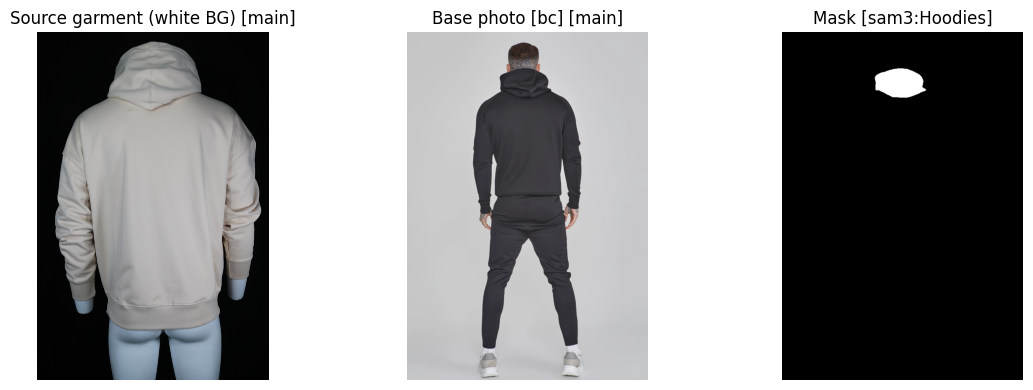

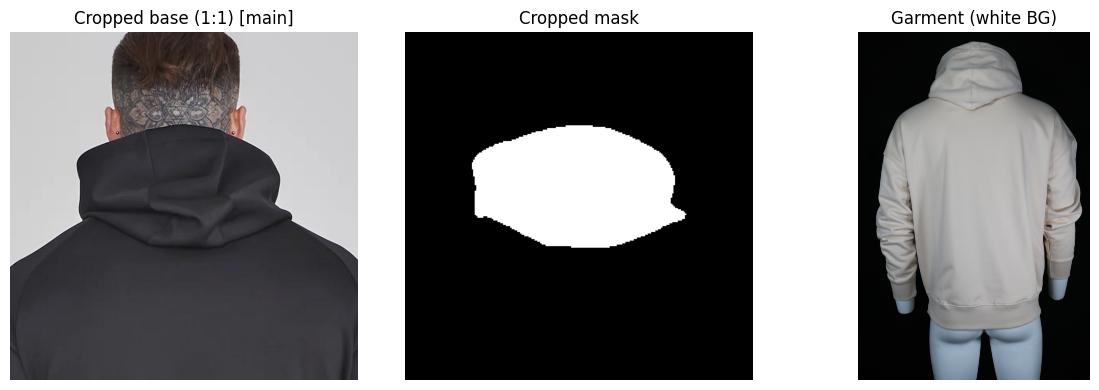

🍌 started...


KeyboardInterrupt: 

In [147]:
# Dispatch
run_list()


#UNASSIGN

In [ ]:
from google.colab import runtime
runtime.unassign()